In [19]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

## 1. 데이터 전처리
### 1) 데이터셋 크기 확인

In [20]:
print(train.shape)
print(test.shape)
print(submission.shape)

(6036000, 8)
(4024000, 7)
(4024000, 2)


### 2) R, C, u_in 정규화
연속변수인 'R, C, u_in'을 StandardScaler를 이용해 정규화한다.

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train[['R', 'C', 'u_in']])

StandardScaler()

In [22]:
train[['R', 'C', 'u_in']] = scaler.transform(train[['R', 'C', 'u_in']])
test[['R', 'C', 'u_in']] = scaler.transform(test[['R', 'C', 'u_in']])

## 2. PyTorch 적용
딥러닝 프레임워크인 PyTorch를 import한다.

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [26]:
X_train = train.iloc[:, 2:7] # 2~6번째 feature: [R, C, time_step, u_in, u_out]
y_train = train.iloc[:, 7] # 7번째 feature: pressure (target)

torch가 연산 가능한 Tensor 데이터타입으로 변환한다.

In [27]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32, device='cuda:0')
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32, device='cuda:0')

순서대로 80개씩 하나의 호흡을 나타내는 자료이므로, 자료의 형태를 75450 x 80 x 5로 변환한다.

In [28]:
X_train_reshaped = X_train.reshape((6036000//80, 80, 5))
y_train_reshaped = y_train.reshape((6036000//80, 80))

학습 도중 성능평가를 위해 train set을 train/valid set로 분할한다.

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_reshaped, y_train_reshaped, test_size=0.2, random_state=216)

In [30]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)

### 2) 뉴럴 네트워크 정의
아래의 방법으로 LSTM과 두 층의 Linear layer로 구성된 뉴럴네트워크를 정의한다.

In [208]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(5, 512, 2, batch_first=True, bidirectional=True)
        self.mlp = nn.Sequential(
            nn.Linear(2 * 512, 256, bias=False),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.mlp(x)

        return x

n_epochs: 데이터셋 반복 학습 횟수 \
learning_rate: 학습 속도

In [210]:
n_epochs = 100
learning_rate = 1e-3

- MSE (Mean squared error) 를 최적화하는 방향으로 학습을 진행하였음.
- Adam optimizer (수정된 경사하강법) 을 적용하여 학습함.
- Learning rate는 Cosine annealing을 적용해 미세 조정함.

In [211]:
model = Net()
model.to('cuda:0')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=n_epochs//2, T_mult=1, eta_min=learning_rate/100)

In [212]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1024, shuffle=False)

In [213]:
for epoch in range(n_epochs):
    print("EPOCH: {}".format(epoch+1))
    train_loss = []
    train_count = 0

    model.train()
    for i, (x, y) in enumerate(train_loader):
        pred = model(x).flatten()
        loss = criterion(pred, y.flatten())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(x.size(0) * loss.detach().cpu().numpy())
        train_count += x.size(0)

    model.eval()

    pred_, y_ = None, None

    with torch.no_grad():
        for i, (x, y) in enumerate(valid_loader):
            pred = model(x).flatten()

            if pred_ is None:
                pred_ = pred.detach().cpu().numpy()
                y_ = y.detach().cpu().numpy()
            else:
                pred_ = np.concatenate((pred_, pred.detach().cpu().numpy()))
                y_ = np.concatenate((y_, y.detach().cpu().numpy()))
        
    valid_loss = criterion(torch.tensor(pred_), torch.tensor(y_).flatten())
    train_loss = sum(train_loss) / train_count

    print('[E {:03}/{:03}] : {:.4f} | {:.4f}'.format(epoch + 1, n_epochs, train_loss, valid_loss))

EPOCH: 1
[E 001/100] : 58.5476 | 19.1308
EPOCH: 2
[E 002/100] : 11.5614 | 7.1348
EPOCH: 3
[E 003/100] : 7.9750 | 5.4423
EPOCH: 4
[E 004/100] : 4.3818 | 3.4007
EPOCH: 5
[E 005/100] : 2.9196 | 2.5542
EPOCH: 6
[E 006/100] : 2.3164 | 1.8885
EPOCH: 7
[E 007/100] : 1.9419 | 1.6925
EPOCH: 8
[E 008/100] : 1.6205 | 1.5556
EPOCH: 9
[E 009/100] : 1.4272 | 1.3002
EPOCH: 10
[E 010/100] : 1.7974 | 2.2457
EPOCH: 11
[E 011/100] : 1.7172 | 1.5518
EPOCH: 12
[E 012/100] : 1.5978 | 1.3487
EPOCH: 13
[E 013/100] : 1.2541 | 1.2183
EPOCH: 14
[E 014/100] : 1.1403 | 1.0964
EPOCH: 15
[E 015/100] : 1.0574 | 1.0489
EPOCH: 16
[E 016/100] : 1.2908 | 1.3095
EPOCH: 17
[E 017/100] : 1.1025 | 0.9800
EPOCH: 18
[E 018/100] : 0.9719 | 0.9408
EPOCH: 19
[E 019/100] : 0.9332 | 0.9010
EPOCH: 20
[E 020/100] : 0.8612 | 0.9344
EPOCH: 21
[E 021/100] : 0.9737 | 0.8638
EPOCH: 22
[E 022/100] : 0.8570 | 0.7669
EPOCH: 23
[E 023/100] : 0.8047 | 0.7850
EPOCH: 24
[E 024/100] : 0.7536 | 0.7500
EPOCH: 25
[E 025/100] : 0.7308 | 0.7507
EPOCH:

In [215]:
X_test = test.iloc[:, 2:7]
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32, device='cuda:0')
X_test_reshaped = X_test.reshape((4024000//80, 80, 5))
test_loader = torch.utils.data.DataLoader(X_test_reshaped, batch_size=1024, shuffle=False)

In [216]:
with torch.no_grad():
    final_pred = None
    
    for i, x in enumerate(test_loader):
        pred = model(x).flatten()

        if final_pred is None:
            final_pred = pred.detach().cpu().numpy()
        else:
            final_pred = np.concatenate((final_pred, pred.detach().cpu().numpy()))

In [217]:
final_pred.shape

(4024000,)

In [218]:
final_pred = np.round(final_pred, 4)

In [219]:
submission.pressure = final_pred

In [220]:
submission.to_csv('result_2113.csv', index=False)

### validation with 1000 samples

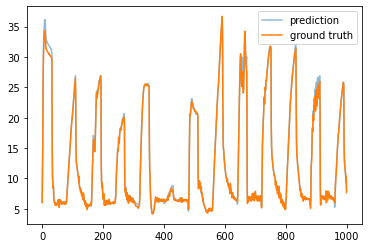

In [239]:
import matplotlib.pyplot as plt
plt.plot(range(1000), pred_[:1000], label='prediction', alpha=0.5)
plt.plot(range(1000), y_.flatten()[:1000], label='ground truth', alpha=1)
plt.legend()
plt.show()